# Cognitive Geometry Paper
## Figure 5
Selection of plots demonstrating an infodesic  {0, 6, 12, 18}.
* grid: 7 x 7 Moore
* beta: 0.07
* data file:
    * "data-7-7-moo-liv-det-1.0-b-0.07-Z.pickle"

In [1]:
from env.grid_room import GridRoom
from utility import display as di
from utility import geometry_plots as gpl

In [50]:
from collections import Counter
sample_size = 100_000

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

import networkx as nx
import pickle
import os

import pandas as pd
import sys


In [4]:
try:
    os.chdir("../../../data/7-7-det/d-perms" )
except OSError as err:
    print("Check directory for loading data: {}".format(os.getcwd()))
    print("Expected directory: {}".format("/code/data/7-7-det"))

In [5]:
fileroot = 'data-7-7-moo-liv-det-1.0-b-0.07-Z'

# load data_dict and infodesic search results
# raw-data and ides files should be in pairs, need to load the data
try:
    # load data_dict
    datafile = fileroot + '.pickle'
    rawfile = fileroot + '-raw.pickle'
    permfile = fileroot + '-perm-3.txt'
    with open(rawfile, 'rb') as infile:
        raw_dict = pickle.load(infile)
        print('data_dict loaded from {}.'.format(infile.name))
    with open(datafile, 'rb') as infile:
        data_dict = pickle.load(infile)
        print('env_dict loaded from {}.'.format(infile.name))
    perms = pd.read_csv(permfile, sep=';', names=["norm_diff", "start", "end", "path", "indirect", "direct"])
    perms['seq'] = perms['path'].apply(lambda path : [int(s) for s in path[1:-1].split(",")])
    perms['interim'] = perms['seq'].apply(lambda x : x[1])
    print('Permutation data loaded from {}.'.format(permfile))

    # prepare output directory
    outdir = os.path.join(os.getcwd(), fileroot)
    if not os.path.exists(outdir):
        os.makedirs(outdir)
except FileNotFoundError as err:
    print('Error loading {}'.format(infile.name), sys.exc_info())
    print('current directory', os.getcwd())


data_dict loaded from data-7-7-moo-liv-det-1.0-b-0.07-Z-raw.pickle.
env_dict loaded from data-7-7-moo-liv-det-1.0-b-0.07-Z.pickle.
Permutation data loaded from data-7-7-moo-liv-det-1.0-b-0.07-Z-perm-3.txt.


In [6]:
# loading data as for previous plots
env = data_dict['env'] # gridworld parameters
shape = data_dict['shape'] # shape of the grid world
nS = env.nS
theta = data_dict['theta'] # threshold for convergence
beta = data_dict['beta'] # trade-off parameter
state_dist = data_dict['state_dist'] # state distribution object used in the simulation

infos = data_dict['infos'] # decision information values
frees = data_dict['frees'] # free energy values
policies = data_dict['policies'] # corresponding free energy optimal policies


In [7]:
# epsilon is the threshold for infodesics
threshold = 0.05

In [8]:
perms.sort_values(['norm_diff', 'start'], inplace=True)
# select rows where normalised difference is less than threshold
ides = perms.loc[perms['norm_diff'] < threshold].reindex()
print('sequences with normalised difference < {}: {}'.format(threshold, len(ides)))

sequences with normalised difference < 0.05: 2780


In [9]:
# select the sequences which pass through an interim state and end at the goal
interim = 6
goal = 18
# df.loc[(df['column_name'] >= A) & (df.['column_name'] <= B)]
sub_ides = ides.loc[(perms['interim']==interim) & (perms['end']==goal)].reindex()
print('sequence which pass through interim {} and end at goal {}: {}'.format(interim, goal, len(sub_ides)))

sequence which pass through interim 6 and end at goal 18: 41


In [10]:
# print first few lines of sequences
with pd.option_context("display.max_rows", 1000):
    print(sub_ides[['norm_diff', 'path', 'indirect', 'direct']].head(6))

        norm_diff         path   indirect     direct
2507    -0.310466   (1, 6, 18)  22.839824  33.123553
92794   -0.310466  (41, 6, 18)  22.839824  33.123553
271     -0.302173   (0, 6, 18)  24.797149  35.534789
108587  -0.302173  (48, 6, 18)  24.797149  35.534789
16090   -0.286216   (7, 6, 18)  24.828276  34.784038
106331  -0.286216  (47, 6, 18)  24.828276  34.784038


## Figure 5 A:
Plot infodesic sequence {36, 6, 18}, showing that the shortest sequence from the opposite side of the grid passes
through the corner.

In [11]:
# project free energy distances onto 3D and 2D spaces
state = np.random.randint(0,1e4) # declare this now so the 2D and 3D use the same value
average_distance = gpl.calculate_symmetric_adjacency_matrix(frees)
coords_3D = gpl.get_matrix_embedding(average_distance, state=state, components=3 )
coords_2D = gpl.get_matrix_embedding(average_distance, state=state, components=2)

In [12]:
def build_graph(coords, shape, D):
    colour_indices = di.select_state_colours(shape)
    G = nx.Graph()
    edges = set()
    for node, coord in enumerate(coords):
        G.add_node(node, pos=tuple(coord), color=di.GRAPH_CMAP(colour_indices[node])[0:3])
        for action in D[node].keys():
            for _, ss, _, _ in D[node][action]:
                if ss is node:
                    pass
                else:
                    edges.add((node, ss))
    G.add_edges_from(list(edges), length=2)
    return G

In [13]:
# build graph using embedding
G = build_graph(coords_2D, data_dict['shape'], env.D)

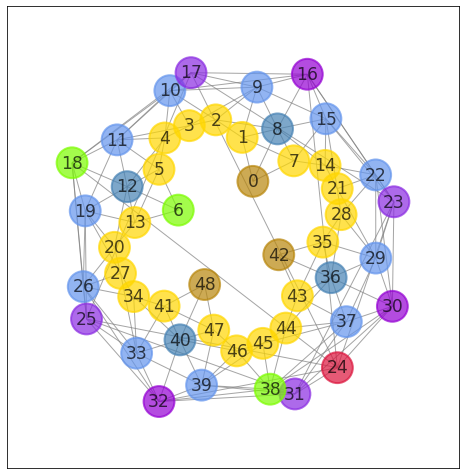

In [14]:
simple_sequence = [38, 6, 18]
di.plot_sequence(shape, G, simple_sequence);

In [15]:
def calculate_perm_free_energy(frees, path):
    indirect = 0
    # print(path, i_path)
    direct = frees[path[-1]][path[0]]
    failed = False
    for i_step in range(len(path) - 1):
        indirect += frees[path[i_step + 1]][path[i_step]]
    return (path[0], path[-1], path, indirect, direct, (indirect - direct)/direct)

In [16]:
s, e, seq, indirect, direct, diff = calculate_perm_free_energy(frees, simple_sequence)
print("Normalised free energy for {} is {}".format(simple_sequence, diff))

Normalised free energy for [38, 6, 18] is -0.1865111734877045


## Figure 5 B:
Similar to figure 4 A, however extended sequence to include {0, 6, 12, 18}, showing that even from close by the
agent utilises the corners.


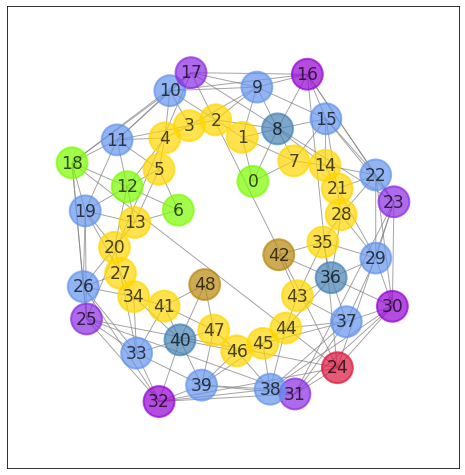

In [17]:
longer_sequence = [0, 6, 12, 18]
di.plot_sequence(shape, G, longer_sequence);

In [18]:
s, e, seq, indirect, direct, diff = calculate_perm_free_energy(frees, longer_sequence)
print("Normalised free energy for {} is {}".format(longer_sequence, diff))

Normalised free energy for [0, 6, 12, 18] is -0.19698342163251054


## Figure 5 C:
Histogram plot showing the number of times a state participates in a 3-state $\varepsilon$-infodesic as the interim
state.  States in a sequence were considered to be infodesics if the free-energy difference normalised by the direct free-energy was less than $\epsilon \in [0,1]$.
\begin{equation}
  -\varepsilon < \frac{\sum_{i=0}^{T-1}\mathcal{F}_{s_{i+1}}(s_i)-\mathcal{F}_{s_T}(s_0)}{\mathcal{F}_{s_T}(s_0)} < \varepsilon.
\end{equation}

In [20]:
from IPython.display import Markdown as md
md(f"The value of epsilon used is {threshold} when calculating the histograms.")

The value of epsilon used is 0.05 when calculating the histograms.

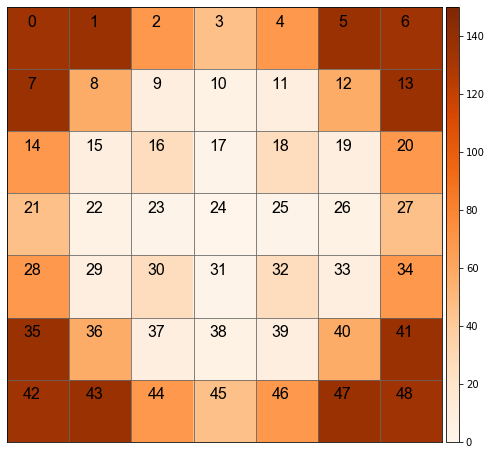

In [21]:
interim_hist = ides['interim'].value_counts().reindex(list(range(nS)), fill_value=0)
di.plot_heatmap(env, interim_hist.values, clim=(0, 150), label=True, label_state=True
                , filename=os.path.join(outdir, '{}-inte-hist-3-{}.pdf'.format(fileroot, threshold)));

### Sampled trajectories:
The goal state is $S=\#18$, which is on the diagonal, between the top right corner and the middle state. We sample trajectories of an agent following a single policy $\pi_{\mathcal{F}}$ from a starting state to reach the goal.  We first plot the decision information and free energy plots with the near open loop policy.

[18]


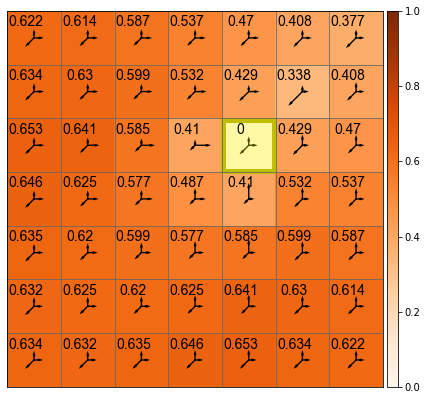

In [32]:
g = 18
pi = policies[g]
I = infos[g]
F = frees[g]
env.update_dynamics_for_goals([g])
print(env.goals)
di.plot_quiver_heatmap_var(env, I, pi, label=True, clim=(0,1));


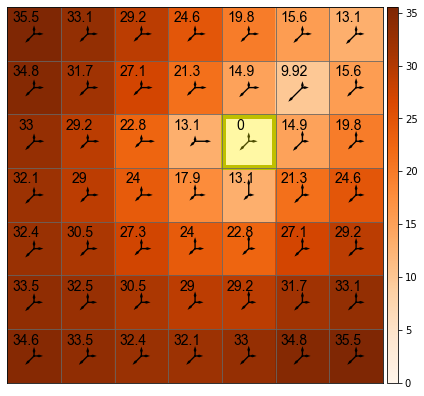

In [34]:
di.plot_quiver_heatmap_var(env, F, pi, label=True);


We now generate actual trajectories for an agent from starting state $S=\#0$$. Considering the infodesic $\langle S_0=\#0, \#6, \#12, S_T=\#18\rangle$

In [51]:
# sample the trajectories from a given state given the policy
s = 0 # starting state
ides_trajectories = []
for _ in range(sample_size):
    ides_trajectories.append(env.get_state_sequence(s, g, pi))
ides_trajectory_state_counts = list(map(Counter,ides_trajectories))
states_visited = {s for cnt in ides_trajectory_state_counts for s in cnt} 
print ("Selection of actual trajectories")
for trajectory in ides_trajectories[0:10]:
    print(trajectory,"\n")

Selection of actual trajectories
[0, 0, 1, 1, 2, 8, 9, 2, 2, 3, 3, 4, 5, 6, 6, 12, 18] 

[0, 0, 1, 1, 1, 2, 3, 4, 4, 5, 5, 11, 17, 10, 16, 9, 10, 11, 4, 4, 4, 5, 6, 6, 12, 18] 

[0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 0, 0, 0, 0, 1, 2, 2, 8, 1, 2, 3, 9, 10, 16, 22, 15, 16, 9, 10, 11, 17, 23, 24, 30, 23, 29, 30, 36, 37, 43, 36, 42, 42, 42, 43, 43, 36, 37, 30, 36, 37, 38, 31, 24, 25, 18] 

[0, 0, 1, 7, 7, 8, 14, 7, 8, 14, 14, 15, 21, 22, 15, 8, 1, 1, 1, 7, 7, 8, 9, 15, 21, 14, 14, 7, 8, 9, 10, 11, 17, 10, 11, 17, 23, 16, 9, 2, 8, 14, 7, 7, 0, 1, 7, 8, 1, 7, 7, 8, 9, 15, 16, 17, 18] 

[0, 1, 1, 7, 7, 8, 9, 2, 8, 14, 15, 8, 1, 7, 0, 0, 1, 7, 8, 14, 15, 8, 14, 15, 16, 17, 23, 24, 30, 31, 32, 38, 39, 32, 33, 34, 27, 33, 39, 45, 45, 38, 31, 37, 30, 23, 16, 22, 15, 16, 9, 2, 2, 3, 3, 9, 10, 11, 17, 10, 3, 3, 3, 9, 10, 11, 12, 13, 13, 19, 20, 26, 32, 33, 26, 27, 33, 26, 27, 33, 34, 27, 20, 13, 13, 6, 6, 6, 12, 18] 

[0, 0, 0, 0, 1, 2, 2, 3, 3, 4, 10, 3, 9, 15, 16, 22, 28, 21, 21, 21, 22, 15, 21, 22, 23,

In [49]:
# average length of the path (sequence of contiguous states)
np.mean(list(map(len, ides_trajectories)))

27.31

In [37]:
cumulative_trajectories = np.zeros(env.nS)
for s in states_visited:
    cumulative_trajectories[s] = np.sum([np.sum([x == s for x in list(cnt.keys())]) for cnt in ides_trajectory_state_counts])/sample_size
print(cumulative_trajectories.reshape(env.shape))

[[1.    1.    0.886 0.729 0.587 0.462 0.314]
 [0.555 0.66  0.682 0.613 0.562 0.513 0.155]
 [0.34  0.439 0.506 0.582 1.    0.108 0.047]
 [0.199 0.253 0.289 0.185 0.144 0.056 0.027]
 [0.117 0.133 0.113 0.083 0.059 0.029 0.018]
 [0.047 0.046 0.041 0.034 0.027 0.021 0.012]
 [0.021 0.025 0.024 0.021 0.02  0.014 0.01 ]]


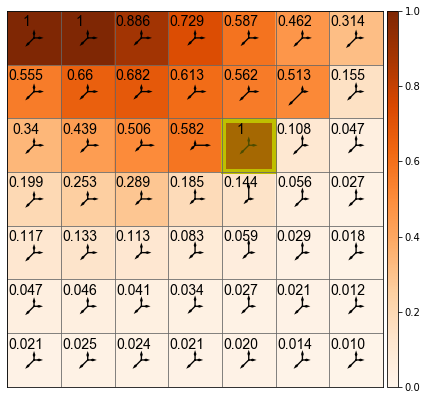

In [52]:
di.plot_quiver_heatmap_var(env, cumulative_trajectories, pi, label=True, clim=(0,1), filename=os.path.join(outdir, '{}-ides-traj-{}->{}.pdf'.format(fileroot, s, g)));